# Predicting Loan Default 3 - Models

In this notebook we perform model fitting, evaluation and selection. 

## Packages

In [1]:
## data handling 
import numpy as np 
import pandas as pd
import polars as pl 
import polars.selectors as cs

## parameter tuning
import optuna 
optuna.logging.set_verbosity(optuna.logging.WARNING)

## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

## sklearn models
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

## pickle 
from pickle import dump, load

## get file path of the data
from private import FINAL_FILE_PATH

## Data

In [2]:
## load datasets
X_train = pd.read_csv(FINAL_FILE_PATH + "X_train.csv", index_col=0)
X_test = pd.read_csv(FINAL_FILE_PATH + "X_test.csv", index_col=0)
y_train = pd.read_csv(FINAL_FILE_PATH + "y_train.csv", index_col=0)
y_test = pd.read_csv(FINAL_FILE_PATH + "y_test.csv", index_col=0)

## Models

### Model Evaluation 

Due to the imbalanced nature of our `default` feature, we must carefully consider our metric. As false negatives (borrowers who default but who were predicted to not default) are much more costly to investors than false positives (borrowers who don't default but who were predicted to default), we will make use of recall as a metric, as well as the area under the ROC curve. 

### Model Selection 

We will use 3-fold cross validation on a large number of models with default parameters. This will help gauge which type of model may be performing best. We will then select the best performing model for hyperparameter tuning. 

In [5]:
models = []

## baseline models 
models.append(('LR', LogisticRegression(max_iter=10000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
## ensemble models 
models.append(('RF', RandomForestClassifier()))
## boosting models 
models.append(('GBM', GradientBoostingClassifier()))
models.append(('AB', AdaBoostClassifier(algorithm="SAMME")))
## neural networks
models.append(('NN', MLPClassifier()))

In [4]:
results = []
names = []

kfold = StratifiedKFold(n_splits=5)
for name, model in models :
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 y_train.values.ravel(),
                                 cv=kfold, 
                                 scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {round(cv_results.mean(), 4)} ({round(cv_results.std(), 6)})")

LR: 0.8734 (0.000921)
KNN: 0.83 (0.000809)
CART: 0.8754 (0.00106)
NB: 0.822 (0.001115)
RF: 0.8961 (0.000562)
GBM: 0.8958 (0.000408)
AB: 0.8786 (0.001366)
NN: 0.8954 (0.001303)


Save the results so they can be loaded later. 

In [5]:
cv_scores = {name:result for (name,result) in zip(names,results)}
dump(cv_scores, open("../models/cv_scores.p", "wb"))

In [3]:
cv_scores = load(open("../models/cv_scores.p", "rb" ))

We plot the results for each model below: 

<Axes: >

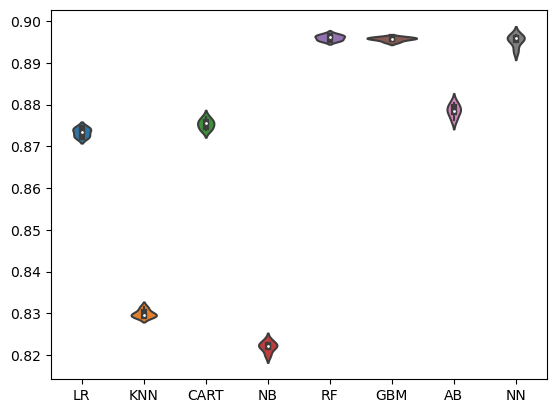

In [12]:
scores = pd.DataFrame(cv_scores)
sns.violinplot(scores)

We see that on default parameters, `RF`, `GBM` and `NN` performed the best. We will therefore tune hyperparameters for these three models. 

## Hyperparameter Tuning 

We use optuna to find the best hyperparameters for the random forest, gradient boosted and neural network models. To use optuna, we create an objective wrapper function which will then be minimized. 

### Random Forest

In [3]:
def rf_objective(trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 200, log=True)
    classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators,
                                            max_depth=24)
    score = cross_val_score(classifier_obj, 
                            X_train, 
                            y_train.values.ravel(), 
                            n_jobs=8, 
                            cv=3)
    accuracy = score.mean()
    return accuracy

In [4]:
rf_study = optuna.create_study(direction="maximize", study_name="RF_study")
rf_study.optimize(rf_objective, n_trials=20, n_jobs=8, show_progress_bar=True)
print(rf_study.best_trial)
print(rf_study.best_params)

  0%|          | 0/20 [00:00<?, ?it/s]

/home/george/anaconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/george/anaconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/george/anaconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/george/anaconda3/envs/DataScience/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were gi

FrozenTrial(number=16, state=1, values=[0.8963857115489811], datetime_start=datetime.datetime(2024, 4, 29, 17, 51, 37, 183819), datetime_complete=datetime.datetime(2024, 4, 29, 18, 7, 30, 821264), params={'rf_n_estimators': 185}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_n_estimators': IntDistribution(high=200, log=True, low=50, step=1)}, trial_id=16, value=None)
{'rf_n_estimators': 185}


In [5]:
dump(rf_study.best_params, open("../models/rf_params.p", "wb"))

### Gradient Boosted Model

In [3]:
def gbm_objective(trial):
    gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 8, log=True)
    gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 50, 200)
    gbm_learning_rate = trial.suggest_float("gbm_learning_rate", 0.1, 1, 
                                                log=True)
    classifier_obj = GradientBoostingClassifier(max_depth=gbm_max_depth,
                                                    n_estimators=gbm_n_estimators,
                                                    learning_rate=gbm_learning_rate)
    score = cross_val_score(classifier_obj, 
                            X_train, 
                            y_train.values.ravel(), 
                            n_jobs=8, 
                            cv=3)
    accuracy = score.mean()
    return accuracy

In [4]:
gbm_study = optuna.create_study(direction="maximize", study_name="RF_study")
gbm_study.optimize(gbm_objective, n_trials=20, n_jobs=8, show_progress_bar=True)
print(gbm_study.best_trial)
print(gbm_study.best_params)

  0%|          | 0/20 [00:00<?, ?it/s]

FrozenTrial(number=3, state=1, values=[0.9267513710348861], datetime_start=datetime.datetime(2024, 4, 29, 18, 48, 1, 459625), datetime_complete=datetime.datetime(2024, 4, 29, 19, 28, 22, 173838), params={'gbm_max_depth': 8, 'gbm_n_estimators': 108, 'gbm_learning_rate': 0.4829411509554302}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'gbm_max_depth': IntDistribution(high=8, log=True, low=1, step=1), 'gbm_n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'gbm_learning_rate': FloatDistribution(high=1.0, log=True, low=0.1, step=None)}, trial_id=3, value=None)
{'gbm_max_depth': 8, 'gbm_n_estimators': 108, 'gbm_learning_rate': 0.4829411509554302}


In [5]:
dump(gbm_study.best_params, open("../models/gbm_params.p", "wb"))

### Multi-Layer Perceptron Model

In [ ]:
def nn_objective(trial):
    nn_hlayer_sizes = trial.suggest_int("nn_hlayer_sizes", 10, 100)
    nn_n_layers = trial.suggest_int("nn_n_layers", 1, 5)
    nn_hidden_layer_sizes = [nn_hlayer_sizes]*nn_n_layers
    classifier_obj = MLPClassifier(hidden_layer_sizes=nn_hidden_layer_sizes)
    
    score = cross_val_score(classifier_obj, 
                            X_train, 
                            y_train.values.ravel(), 
                            n_jobs=8, 
                            cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
nn_study = optuna.create_study(direction="maximize", study_name="RF_study")
nn_study.optimize(nn_objective, n_trials=20, n_jobs=8, show_progress_bar=True)
print(nn_study.best_trial)
print(nn_study.best_params)

In [ ]:
dump(nn_study.best_params, open("../models/nn_params.p", "wb"))